In [8]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('ggplot')
import torch
from torch.utils.data import random_split, DataLoader, TensorDataset
from torch.distributions import multivariate_normal, binomial
from sklearn import datasets
import numpy as np
from torch.autograd import Variable
import ipdb
np.random.seed(0)

In [97]:
class coupling_net(torch.nn.Module):
    def __init__(self, num_in, num_hid=256, out_dim=10):
        super(coupling_net, self).__init__()
        self.out_dim = out_dim
#         self.layers = torch.nn.Sequential(torch.nn.Linear(num_in, num_hid),
#                          torch.nn.Sigmoid(),
#                          torch.nn.Linear(num_hid,num_hid),
#                          torch.nn.Sigmoid(),
#                          torch.nn.Linear(num_hid,out_dim))
        self.layers = torch.nn.Linear(num_in, out_dim)

    def forward(self,x):
        features = self.layers(x)
        return torch.einsum('bi,ci->bc',features,features) * (1. / self.out_dim)

In [5]:
def cohn_loss(phases, masks, eps=1e-5, burn_in_prop=.5):
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    post_burn_in_steps = T - int(burn_in_prop * T)
    masked_phases = phases * masks.unsqueeze(0)
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(2))**2 + (yy.sum(2))**2) / group_size
    synch = 1 - go.mean(1)
    
    mean_angles = torch.atan2(yy.sum(2), xx.sum(2))
    phase_diffs = mean_angles.unsqueeze(2) - mean_angles.unsqueeze(1)
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps)) + np.log(2)).sum((1,2)) / (num_groups)**2
    desynch -= c_min
    loss = .5*(synch + desynch)[-1*post_burn_in_steps:]
    return loss.mean()

# def cohn_loss(phases, masks, eps=1e-5, burn_in_prop=.5):
#     num_groups = masks.shape[1]
#     group_size = masks.sum(2)
#     T = phases.shape[0]
#     post_burn_in_steps = T - int(burn_in_prop * T)
#     masked_phases = phases.unsqueeze(2) * masks.unsqueeze(0)
#     xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
#     yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
#     go = torch.sqrt((xx.sum(3))**2 + (yy.sum(3))**2) / group_size
#     synch = 1 - go.mean(2)
    
#     mean_angles = torch.atan2(yy.sum(3), xx.sum(3))
#     phase_diffs = mean_angles.unsqueeze(3) - mean_angles.unsqueeze(2)
#     desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps)) + np.log(2)).sum((2,3)) / (num_groups)**2

#     loss = .5*(synch + desynch)[-1*post_burn_in_steps:,:]
#     return loss.mean()

In [6]:
def phase_evol(phases, masks, save_name=None):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[1]
        annot_bool = [True] * group_num
        colors = {}
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = (mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[0][num][i]:
                    plt.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        plt.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num),
                                 horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        plt.xlabel('Time')
        plt.ylabel('Phase')
        plt.title('Phase Evolution')
        plt.ylim([0,2*np.pi])
    else:
        for i in range(phases.shape[1]):
            plt.plot(phases[:, i])
        plt.xlabel('Time')
        plt.ylabel('Phase')
        plt.title('Phase Evolution')
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(save_name + '.png')
    else:
        plt.show()
    plt.close()

In [40]:
def OptimizeCouplingNet(batch_size, LossFunc, num_features=32, iterations=100,
                     lr=0.1, kura_steps=50, burn_in_prop=.5,alpha=.1, normalized=False, eps=1e-12):
    gen = torch.Generator()
    gen = gen.manual_seed(0)
    net = coupling_net(4, out_dim=num_features)
    lh = []
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    init_phase = torch.normal(np.pi,.1,(batch_size,), generator=gen).float().unsqueeze(0)
    for _ in range(iterations):
        batch_inds = torch.randint(150, (batch_size,))
        batch = X[batch_inds,:]
        target     = Y[batch_inds]
        masks = torch.FloatTensor(batch_size,3).zero_()
        masks.scatter_(1,target.unsqueeze(1),1).transpose_(1,0)
        coupling = net(batch.float())
        opt.zero_grad()
        phase = kuramoto(init_phase, coupling, steps=kura_steps,alpha=alpha)
        loss = LossFunc(phase, masks, burn_in_prop=burn_in_prop, eps=eps)
        lh.append(loss.detach().numpy())
        loss.backward()
        opt.step()
    phase_evol(phase.detach().numpy(), masks.unsqueeze(0).data.numpy())
    return lh, net

# def OptimizeCouplingNet(batch_size, num_samples, LossFunc, num_features=32, iterations=100,
#                      lr=0.1, kura_steps=50, burn_in_prop=.5,alpha=.1, normalized=False):
#     gen = torch.Generator()
#     gen = gen.manual_seed(0)
#     net = coupling_net(num_samples*4, out_dim=num_samples)
#     lh = []
#     opt = torch.optim.Adam(net.parameters(), lr=lr)
#     init_phase = torch.normal(np.pi,.1,(batch_size, num_samples), generator=gen).float()
#     for _ in range(iterations):
#         batch_inds = torch.randint(150, (batch_size*num_samples,))
#         batch = X[batch_inds,:].reshape(batch_size,num_samples*4)
#         target     = Y[batch_inds].reshape(batch_size,num_samples)
#         masks = torch.FloatTensor(batch_size,3, num_samples).zero_()
#         masks.scatter_(1,target.unsqueeze(1),1)
#         coupling = net(batch.float(), correlation=True)
#         opt.zero_grad()
#         phase = kuramoto(init_phase, coupling, steps=kura_steps,alpha=alpha)
#         loss = LossFunc(phase, masks, burn_in_prop=burn_in_prop)
#         lh.append(loss.detach().numpy())
#         loss.backward()
#         opt.step()
#     phase_evol(phase[:,0,:].detach().numpy(), masks[0,...].unsqueeze(0).data.numpy())
#     return lh, net

In [72]:
def OptimizeCoupling(batch_size, LossFunc, iterations=100,
                     lr=0.1, kura_steps=50, burn_in_prop=.5,alpha=.1, normalized=False, eps=1e-12):
    gen = torch.Generator()
    gen = gen.manual_seed(0)
    lh = []
    coupling = Variable(torch.normal(0.0, .01, size=(int(batch_size*(batch_size - 1)/2),),
                                                     generator=gen), requires_grad=True)
    opt = torch.optim.Adam((coupling,), lr=lr)
    triu_ind = torch.triu_indices(row=batch_size, col=batch_size, offset=1)
    init_phase = torch.normal(np.pi,.1,(batch_size,), generator=gen).float().unsqueeze(0)
    for _ in range(iterations):
        batch  = X
        target = Y
        masks  = torch.FloatTensor(batch_size,3).zero_()
        masks.scatter_(1,target.unsqueeze(1),1).transpose_(1,0)
        full_coupling = torch.zeros(batch_size,batch_size)
        full_coupling[triu_ind[0], triu_ind[1]] = coupling
        opt.zero_grad()
        phase = kuramoto(init_phase, full_coupling, steps=kura_steps,alpha=alpha)
        loss = LossFunc(phase, masks, burn_in_prop=burn_in_prop, eps=eps)
        lh.append(loss.detach().numpy())
        loss.backward()
        opt.step()
    phase_evol(phase.detach().numpy(), masks.unsqueeze(0).data.numpy())
    return lh, coupling

In [9]:
def kuramoto(phases, coupling, steps=50, alpha=.01):
    phase_record = [phases]
    for i in range(steps):
        n = coupling.shape[1]
        phase_diffs = torch.sin(phases - phases.transpose(1,0))
        delta = alpha *((coupling*phase_diffs).sum(1) / n)
        phases = phases + delta
        phase_record.append(phases)
    return torch.stack(phase_record)

In [10]:
# def kuramoto(phases, coupling, steps=50, alpha=.01):
#     phase_record = [phases]
#     for i in range(steps):
#         n = coupling.shape[1]
#         phase_diffs = torch.sin(phases.unsqueeze(2) - phases.unsqueeze(1))
#         delta = alpha *((coupling*phase_diffs).sum(2) / n)
#         phases = phases + delta
#         phase_record.append(phases)
#     return torch.stack(phase_record)

In [11]:
# def kuramoto(phases, omega, coupling, steps=50, alpha=.01):
#     phase_record = [phases]
#     for i in range(steps):
#         n = coupling.shape[2]
#         ipdb.set_trace()
#         delta = alpha *(omega + \
#                 (torch.bmm(coupling, torch.sin(phases).unsqueeze(2).float()).squeeze(2) * torch.cos(phases) -
#                 torch.bmm(coupling, torch.cos(phases).unsqueeze(2).float()).squeeze(2) * torch.sin(phases)) / n)
#         phases = phases + delta
#         phase_record.append(phases)
#     return torch.stack(phase_record)

In [70]:
iris = datasets.load_iris()
X = torch.tensor(iris.data) # we only take the first two features.
Y = torch.tensor(iris.target)

eps=1e-12
num_groups=3
splay_phases = torch.linspace(0, 2*np.pi, num_groups+1)[:-1]
phase_diffs = splay_phases.unsqueeze(1) - splay_phases.unsqueeze(0)
c_min = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps))).sum((0,1)) / (num_groups)**2



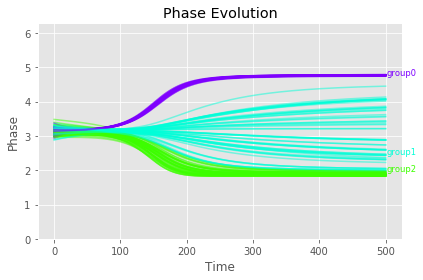

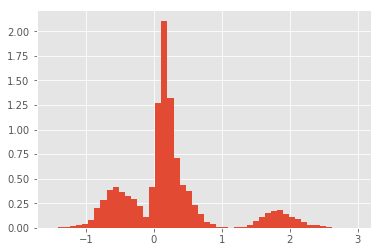

In [95]:
np.random.seed(1)
batch_size = 150
torch.manual_seed(1)
lh, net = OptimizeCouplingNet(batch_size,cohn_loss, num_features=1024, iterations=500, lr=.01, burn_in_prop=.5, kura_steps=500,
                              alpha=.1, eps=eps)
batch = X
coupling = net.forward(batch.float())
plt.hist(coupling.reshape(-1).detach().numpy(), 50, density=True)
plt.show()

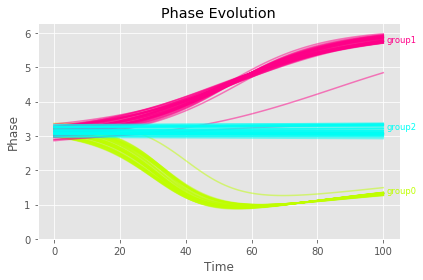

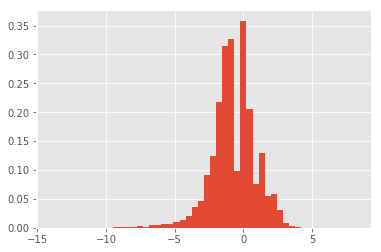

In [73]:
batch_size = 150
lh, coupling = OptimizeCoupling(batch_size,cohn_loss,iterations=250, lr=.1, kura_steps=100, eps=eps)
plt.hist(coupling.reshape(-1).detach().numpy(), 50, density=True)
plt.show()

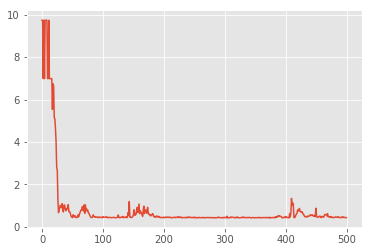

In [96]:
plt.plot(lh)
plt.show()
plt.close()

In [7]:
# Make GMM data
import torch.distributions as D
from torch.distributions.mixture_same_family import MixtureSameFamily
M = 5
n = 2
mix = D.Categorical(torch.ones(M,))
comp = D.Independent(D.Normal(
             torch.randn(M,n), torch.rand(M,n)), 1)
gmm = mixture_same_family.MixtureSameFamily(mix, comp)

ImportError: No module named 'torch.distributions.mixture_same_family'